In [382]:
#Import Libraries

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import numpy as np



#Importing data and visualizing

In [383]:

ticker = 'AAPL'
start = '2020-01-01'  # Start date
end = '2024-01-01'  # End date (if you want just one day)

data = yf.download(ticker, start=start, end=end, interval='1d')


print(data.head())



[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960464  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251122  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826859  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484337  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650345  132079200


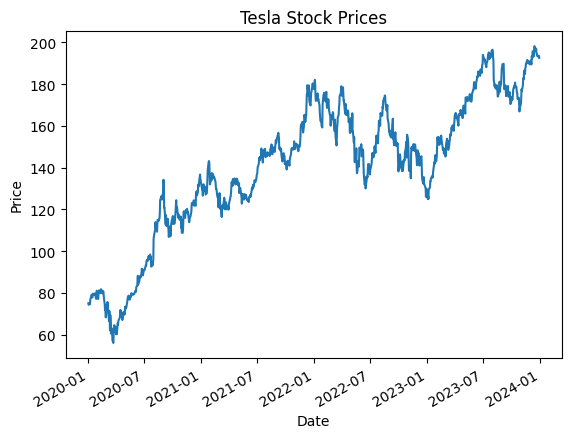

In [384]:
# Fetch intraday data at 1-day intervals and create line plot to visualize pricing

data['Close'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Tesla Stock Prices")
plt.show()

In [385]:
# Check for missing values
print(data.isnull().sum())

# Fill or drop missing values (if any)
data = data.dropna()

# Create target variable (next day's closing price)
data['Next_Close'] = data['Close'].shift(-1)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


# Feature Engineering

In [386]:
#Implementing Simple Moving Average

def simpleMovingAverage(data, period):
  sma = data.rolling(window=period).mean()
  return sma

#Calculate the moving average at various periods
for i in range(0, 3):
  data[f'SMA_{5*(2**i)}'] = simpleMovingAverage(data['Close'], 5*(2**i))
  # Fill NaNs using both forward and backward fill to handle edge cases
  data.fillna(method='ffill', inplace=True)
  data.fillna(method='bfill', inplace=True)

  corr, _ = pearsonr(data[f'SMA_{5*(2**i)}'], data['Next_Close'])
  print(f'Correlation for {5*(2**i)} day simple moving average: {corr}')




Correlation for 5 day simple moving average: 0.993680059860858
Correlation for 10 day simple moving average: 0.9891794786579196
Correlation for 20 day simple moving average: 0.9801940805507844


In [387]:
#Implementing Exponential Moving Average

def exponentialMovingAverage(data, period):
  ema = data.ewm(span=period, adjust=False).mean()
  return ema

#Calculate exponential moving average at various periods
for i in range(0, 3):
  data[f'EMA_{5*(2**i)}'] = exponentialMovingAverage(data['Close'], 5*(2**i))
  # Fill NaNs using both forward and backward fill to handle edge cases
  data.fillna(method='ffill', inplace=True)
  data.fillna(method='bfill', inplace=True)

  corr, _ = pearsonr(data[f'EMA_{5*(2**i)}'], data['Next_Close'])
  print(f'Correlation for {5*(2**i)} day exponential moving average: {corr}')


Correlation for 5 day exponential moving average: 0.9947688669326078
Correlation for 10 day exponential moving average: 0.9914580560057451
Correlation for 20 day exponential moving average: 0.9849671358444991


In [388]:
def relativeStrengthIndex(data, period):
  # Calculate the difference between the closing price and the previous day's closing price
  deltas = [data[i] - data[i - 1] for i in range(1, len(data))]

  # Initialize gains and losses lists
  gains = [max(0, delta) for delta in deltas]
  losses = [max(0, -delta) for delta in deltas]

  # Calculate the average gain and loss for each period
  avg_gains = [None] * (period - 1) #Initialize with None for the first period-1 values
  avg_losses = [None] * (period - 1)

  for i in range(period - 1, len(data)):
    avg_gains.append(sum(gains[i - period + 1:i + 1]) / period)
    avg_losses.append(sum(losses[i - period + 1:i + 1]) / period)

  # Calculate the relative strength
  rs = []

  for i in range(len(avg_gains)):
    if(avg_losses[i] == 0):
      rs.append(None)
    elif avg_losses[i] is None or avg_gains[i] is None: # Handle cases where avg_gain or avg_loss is None
      rs.append(None)
    else:
      rs.append(avg_gains[i] / avg_losses[i])

  #Calcualte rsi
  rsi = []

  for i in range(len(rs)):
    if(rs[i] != None):
      rsi.append(100 - (100 / (1 + rs[i])))
    else:
      rsi.append(None)

  return rsi


#Calculate relative strength index at various periods
for i in range(0, 3):
  data[f'RSI_{5*(2**i)}'] = relativeStrengthIndex(data['Close'], 5*(2**i))
  # Fill NaNs using both forward and backward fill to handle edge cases
  data.fillna(method='ffill', inplace=True)
  data.fillna(method='bfill', inplace=True)

  corr, _ = spearmanr(data[f'RSI_{5*(2**i)}'], data['Next_Close'])
  print(f'Correlation for {5*(2**i)} day relative strength index: {corr}')

Correlation for 5 day relative strength index: 0.0140139868098776
Correlation for 10 day relative strength index: 0.05325424039220578
Correlation for 20 day relative strength index: 0.10779976065150959


In [389]:
def bollingerBands(data, window, num_std_dev):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return rolling_mean, upper_band, lower_band

#Calculate Bollinger Bands
data['BB_Mean'], data['BB_Upper'], data['BB_Lower'] = bollingerBands(data['Close'], 20, 2)

# Fill NaNs using both forward and backward fill to handle edge cases
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

corr, _ = pearsonr(data['BB_Mean'], data['Next_Close'])
print(f'Correlation for Bollinger Bands Mean: {corr}')
corr, _ = pearsonr(data['BB_Upper'], data['Next_Close'])
print(f'Correlation for Bollinger Bands Upper: {corr}')
corr, _ = pearsonr(data['BB_Lower'], data['Next_Close'])
print(f'Correlation for Bollinger Bands Lower: {corr}')


Correlation for Bollinger Bands Mean: 0.9801940805507844
Correlation for Bollinger Bands Upper: 0.9747153124877688
Correlation for Bollinger Bands Lower: 0.9754038470072797


In [390]:
#Calculating MACD Indicator

def MACD_Line(data, short_window=12, long_window=26):
    short_ema = exponentialMovingAverage(data, short_window)
    long_ema = exponentialMovingAverage(data, long_window)
    macd_line = short_ema - long_ema
    return macd_line

#Calculate MACD Line
data['MACD_Line'] = MACD_Line(data['Close'])

# Fill NaNs using both forward and backward fill to handle edge cases
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

corr, _ = pearsonr(data['MACD_Line'], data['Next_Close'])
print(f'Correlation for MACD Line: {corr}')


Correlation for MACD Line: 0.16732660416277523


In [391]:
# Calculate Daily Returns
data['Returns'] = data['Close'].pct_change()

# Fill NaNs using both forward and backward fill to handle edge cases
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

corr, _ = spearmanr(data['Returns'], data['Next_Close'])
print(f'Correlation for Daily Returns: {corr}')

# Calculate Day of the Week for cyclical patterns
data['Day_of_Week'] = data.index.dayofweek

#Calculate month
data['Month'] = data.index.month

Correlation for Daily Returns: 0.0077386972236428596


#Normalizing data and creating train and test split

In [393]:
from sklearn.model_selection import train_test_split

#Selecting features

features = [col for col in data.columns if col != 'Next_Close']
target = 'Next_Close'

X = data[features]
y = data[target]


#Normalize data using Min-Max Scaling
X_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

#Implementing Linear Regression from scratch

In [394]:
#Predicting functions

#Initialize parameters
W = np.random.randn(len(features))
b = 0

#prediction function - predicts with current weight values
def predict(X, W, b):
  return np.dot(X, W) + b

#Cost computing function
def compute_cost(X, y_true, W, b):
  m = len(y_true)
  predictions = predict(X, W, b)
  cost = np.sum((predictions - y_true) ** 2) / (2 * m)
  return cost


##Implementing all momentum, RMSprop, and Adams optimizer from scratch

In [395]:
#Training functions

def compute_gradient(X, y_true, W, b):
  dW = np.dot(X.T, (predict(X, W, b) - y_true)) / len(y_true)
  db = np.sum(y_true - predict(X, W, b)) / len(y_true)

  return dW, db

#Implementing gradient descent with momentum for more efficient learning
def compute_gradient_momentum(X, y_true, W, b, beta=0.9, dW_momentum=np.zeros(len(W)), db_momentum=0):
  dW = np.dot(X.T, (predict(X, W, b) - y_true)) / len(y_true)
  db = np.sum(y_true - predict(X, W, b)) / len(y_true)

  dW_momentum = beta * dW_momentum + (1 - beta) * dW
  db_momentum = beta * db_momentum + (1 - beta) * db

  return dW_momentum, db_momentum

#Implementing RMSprop for more efficient learning
def compute_gradient_rmsprop(X, y_true, W, b, alpha=0.01, beta=0.999, dW_rmsprop=np.zeros(len(W)), db_rmsprop=0):
  dW = np.dot(X.T, (predict(X, W, b) - y_true)) / len(y_true)
  db = np.sum(y_true - predict(X, W, b)) / len(y_true)

  dW_rmsprop = beta * dW_rmsprop + (1 - beta) * dW ** 2
  db_rmsprop = beta * db_rmsprop + (1 - beta) * db ** 2

  epsilon = 1e-8 #Very small value to prevent from dividing by 0

  #Dividing by the square root of the gradient reduces large steps in incorrect directions
  dW_corrected = dW / np.sqrt(dW_rmsprop + epsilon)
  db_corrected = db / np.sqrt(db_rmsprop + epsilon)

  return dW_corrected, db_corrected

#Implementing Adams optimizer by combining momentum and rmsprop for more efficient learning
def compute_gradient_Adams(X, y_true, W, b, iteration, alpha=0.01, beta1=0.9, beta2=0.999, dW_rmsprop=np.zeros(len(W)), db_rmsprop=0, dW_momentum=np.zeros(len(W)), db_momentum=0):
  dW = np.dot(X.T, (predict(X, W, b) - y_true)) / len(y_true)
  db = np.sum(y_true - predict(X, W, b)) / len(y_true)

  #Calculating momentum
  dW_momentum = beta1 * dW_momentum + (1 - beta1) * dW
  db_momentum = beta1 * db_momentum + (1 - beta1) * db

  #Calculating rmsprop
  dW_rmsprop = beta2 * dW_rmsprop + (1 - beta2) * dW ** 2
  db_rmsprop = beta2 * db_rmsprop + (1 - beta2) * db ** 2

  #Bias correction
  dW_momentum = dW_momentum / (1 - beta1 ** iteration)
  db_momentum = db_momentum / (1 - beta1 ** iteration)
  dW_rmsprop = dW_rmsprop / (1 - beta2 ** iteration)
  db_rmsprop = db_rmsprop / (1 - beta2 ** iteration)

  #Combining rmsprop and momentum
  epsilon = 1e-8 #Very small value to prevent from dividing by 0

  dW_corrected = dW_momentum / np.sqrt(dW_rmsprop + epsilon)
  db_corrected = db_momentum / np.sqrt(db_rmsprop + epsilon)

  return dW_corrected, db_corrected


#Training function
def train(X_train, y_train, W, b, learning_rate, num_iterations):
  traincost_history = []
  valcost_history = []

  for i in range(1, num_iterations+1):
    dW, db = compute_gradient_Adams(X_train, y_train, W, b, i)
    W = W - (learning_rate * dW)
    b = b - (learning_rate * db)
    train_cost = compute_cost(X_train, y_train, W, b)


    if(len(traincost_history) != 0 and train_cost > traincost_history[-1]):
      print('Stopping...')
      break
    print(f"Iteration {i}: Training Cost = {train_cost}")
    print(f"Iteration {i}: Validation Cost = {compute_cost(X_test, y_test, W, b)}")

    traincost_history.append(train_cost)
    valcost_history.append(compute_cost(X_test, y_test, W, b))

  return W, b, traincost_history, valcost_history

##Coding mini-batch gradient descent from scratch

In [396]:
#Implementing mini-batch gradient descent

def create_mini_batches(X, y, batch_size=128):
  Xmini_batches = []
  ymini_batches = []

  #Shuffle data while keeping X,y pairings
  indices = np.random.permutation(len(X))
  X_shuffled = X.iloc[indices]
  y_shuffled = y.iloc[indices]

  for i in range(0, len(X), batch_size):
    X_batch = X_shuffled.iloc[i:i+batch_size]
    y_batch = y_shuffled.iloc[i:i+batch_size]
    Xmini_batches.append(X_batch)
    ymini_batches.append(y_batch)

  return Xmini_batches, ymini_batches

#Training function for mini_batches
def train_batches(X_train, y_train, W, b, learning_rate, num_iterations):
  traincost_history = []
  valcost_history = []

  for i in range(1, num_iterations+1):
    Xmini_batches, ymini_batches = create_mini_batches(X_train, y_train)

    #Computing gradient for each mini batch
    for j in range(len(Xmini_batches)):
      dW, db = compute_gradient_Adams(Xmini_batches[j], ymini_batches[j], W, b, i)
      W = W - (learning_rate * dW)
      b = b - (learning_rate * db)

    train_cost = compute_cost(X_train, y_train, W, b)
    val_cost = compute_cost(X_test, y_test, W, b)

    if(len(traincost_history) != 0 and train_cost > traincost_history[-1]):
      print('Stopping...')
      break

    print(f"Iteration {i}: Training Cost = {train_cost}")
    print(f"Iteration {i}: Validation Cost = {val_cost}")

    traincost_history.append(train_cost)
    valcost_history.append(compute_cost(X_test, y_test, W, b))

  return W, b, traincost_history, valcost_history

##Implementing l2 regularization from scratch

In [397]:
#Training with l2 regularization

#Cost computing function with l2
def compute_cost_l2(X, y_true, W, b, lambd=0.1):
  m = len(y_true)
  predictions = predict(X, W, b)
  cost = np.sum((predictions - y_true) ** 2) / (2 * m)
  l2_term = (lambd / (2 * m)) * np.sum(W ** 2)

  return cost + l2_term

def compute_gradient_Adams_l2(X, y_true, W, b, iteration, alpha=0.01, beta1=0.9, beta2=0.999, dW_rmsprop=np.zeros(len(W)), db_rmsprop=0, dW_momentum=np.zeros(len(W)), db_momentum=0, lambd=0.1):
  dW = np.dot(X.T, (predict(X, W, b) - y_true)) / len(y_true) + ((lambd/len(y_true)) * W)
  db = np.sum(y_true - predict(X, W, b)) / len(y_true)

  #Calculating momentum
  dW_momentum = beta1 * dW_momentum + (1 - beta1) * dW
  db_momentum = beta1 * db_momentum + (1 - beta1) * db

  #Calculating rmsprop
  dW_rmsprop = beta2 * dW_rmsprop + (1 - beta2) * dW ** 2
  db_rmsprop = beta2 * db_rmsprop + (1 - beta2) * db ** 2

  #Bias correction
  dW_momentum = dW_momentum / (1 - beta1 ** iteration)
  db_momentum = db_momentum / (1 - beta1 ** iteration)
  dW_rmsprop = dW_rmsprop / (1 - beta2 ** iteration)
  db_rmsprop = db_rmsprop / (1 - beta2 ** iteration)

  #Combining rmsprop and momentum
  epsilon = 1e-8 #Very small value to prevent from dividing by 0

  dW_corrected = dW_momentum / np.sqrt(dW_rmsprop + epsilon)
  db_corrected = db_momentum / np.sqrt(db_rmsprop + epsilon)

  return dW_corrected, db_corrected

#Training function
def train_l2(X_train, y_train, W, b, learning_rate, num_iterations):
  traincost_history = []
  valcost_history = []
  minimum = 9999999

  for i in range(1, num_iterations+1):
    dW, db = compute_gradient_Adams_l2(X_train, y_train, W, b, i)
    W = W - (learning_rate * dW)
    b = b - (learning_rate * db)
    train_cost = compute_cost_l2(X_train, y_train, W, b)

    if(train_cost < minimum):
      minimum = train_cost

    #Early stopping to prevent overfitting
    if(len(traincost_history) != 0 and train_cost > minimum + 0.1):
      print('Stopping...')
      break


    print(f"Iteration {i}: Training Cost = {train_cost}")
    print(f"Iteration {i}: Validation Cost = {compute_cost_l2(X_test, y_test, W, b)}")

    traincost_history.append(train_cost)
    valcost_history.append(compute_cost_l2(X_test, y_test, W, b))

  return W, b, traincost_history, valcost_history

In [398]:
#Training linear regression model
W, b, traincost_history, valcost_history = train_l2(X_train, y_train, W, b, learning_rate=0.01, num_iterations=2000)

Iteration 1: Training Cost = 10232.787202764479
Iteration 1: Validation Cost = 10527.708126103516
Iteration 2: Training Cost = 10220.512933818383
Iteration 2: Validation Cost = 10515.036664726653
Iteration 3: Training Cost = 10209.981853849897
Iteration 3: Validation Cost = 10504.164827662858
Iteration 4: Training Cost = 10200.406487387028
Iteration 4: Validation Cost = 10494.279649392947
Iteration 5: Training Cost = 10191.422471982218
Iteration 5: Validation Cost = 10485.004973608284
Iteration 6: Training Cost = 10182.827111197566
Iteration 6: Validation Cost = 10476.131543136522
Iteration 7: Training Cost = 10174.494367991321
Iteration 7: Validation Cost = 10467.529241668373
Iteration 8: Training Cost = 10166.339763753704
Iteration 8: Validation Cost = 10459.110856579215
Iteration 9: Training Cost = 10158.30352717293
Iteration 9: Validation Cost = 10450.81468232629
Iteration 10: Training Cost = 10150.341608758486
Iteration 10: Validation Cost = 10442.595244113452
Iteration 11: Traini

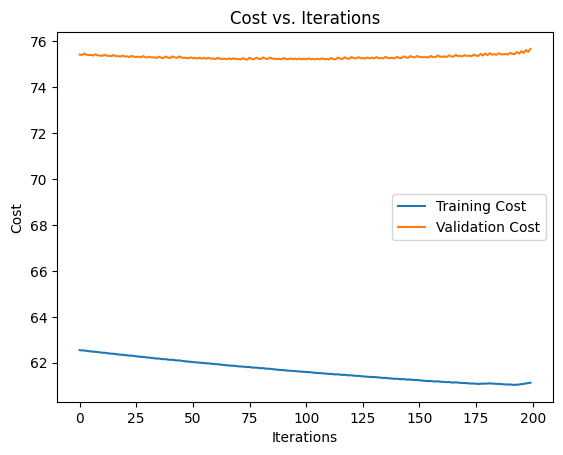

In [399]:
plt.plot(traincost_history[-200:], label='Training Cost')
plt.plot(valcost_history[-200:], label='Validation Cost')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')
plt.show()

#Evaluating model on most recent data

In [422]:
ticker = 'AAPL'
start = '2024-01-01'  # Start date
end = '2024-06-08'  # End date (if you want just one day)

test_data = yf.download(ticker, start=start, end=end, interval='1d')


print(test_data.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-01-02  187.149994  188.440002  183.889999  185.639999  185.152283   
2024-01-03  184.220001  185.880005  183.429993  184.250000  183.765930   
2024-01-04  182.149994  183.089996  180.880005  181.910004  181.432098   
2024-01-05  181.990005  182.759995  180.169998  181.179993  180.703995   
2024-01-08  182.089996  185.600006  181.500000  185.559998  185.072495   

              Volume  
Date                  
2024-01-02  82488700  
2024-01-03  58414500  
2024-01-04  71983600  
2024-01-05  62303300  
2024-01-08  59144500  


#Adding all features to test data

In [425]:
# Check for missing values
print(test_data.isnull().sum())

# Fill or drop missing values (if any)
data = test_data.dropna()

# Create target variable (next day's closing price)
test_data['Next_Close'] = test_data['Close'].shift(-1)

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Next_Close    1
dtype: int64


In [426]:
#Calculate the moving average at various periods
for i in range(0, 3):
 test_data[f'SMA_{5*(2**i)}'] = simpleMovingAverage(test_data['Close'], 5*(2**i))
 # Filla NaNs using both forward and backward fill to handle edge cases
 test_data.fillna(method='ffill', inplace=True)
 test_data.fillna(method='bfill', inplace=True)




#Calculate exponential moving average at various periods
for i in range(0, 3):
 test_data[f'EMA_{5*(2**i)}'] = exponentialMovingAverage(test_data['Close'], 5*(2**i))
 # Fill NaNs using both forward and backward fill to handle edge cases
 test_data.fillna(method='ffill', inplace=True)
 test_data.fillna(method='bfill', inplace=True)


#Calculate relative strength index at various periods
for i in range(0, 3):
 test_data[f'RSI_{5*(2**i)}'] = relativeStrengthIndex(test_data['Close'], 5*(2**i))
 # Fill NaNs using both forward and backward fill to handle edge cases
 test_data.fillna(method='ffill', inplace=True)
 test_data.fillna(method='bfill', inplace=True)


#Calculate Bollinger Bands
test_data['BB_Mean'], test_data['BB_Upper'], test_data['BB_Lower'] = bollingerBands(test_data['Close'], 20, 2)


# Fill NaNs using both forward and backward fill to handle edge cases
test_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='bfill', inplace=True)


#Calculate MACD Line
test_data['MACD_Line'] = MACD_Line(test_data['Close'])


# Fill NaNs using both forward and backward fill to handle edge cases
test_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='bfill', inplace=True)


# Calculate Daily Returns
test_data['Returns'] = test_data['Close'].pct_change()


# Fill NaNs using both forward and backward fill to handle edge cases
test_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='bfill', inplace=True)


# Calculate Day of the Week for cyclical patterns
test_data['Day_of_Week'] = test_data.index.dayofweek


#Calculate month
test_data['Month'] = test_data.index.month



In [427]:
X_recent = test_data[features]
y_recent = test_data['Next_Close']

#Normalize data
X_recent_scaled = (X_recent - X_recent.min(axis=0)) / (X_recent.max(axis=0) - X_recent.min(axis=0))


In [428]:
#Using trained model weights to make predictions
predictions = predict(X_recent_scaled, W, b)

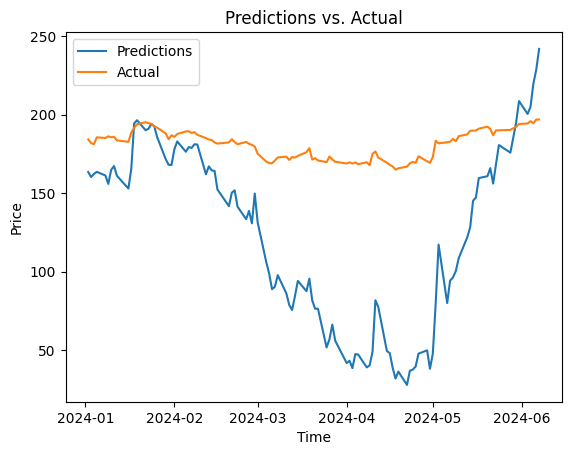

RMSE: 74.95787682875802
Correlation: 0.9253200023104705


In [429]:
#Plotting predictions vs true values to determine errors

plt.plot(test_data.index, predictions, label='Predictions')
plt.plot(test_data.index, y_recent, label='Actual')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predictions vs. Actual')
plt.show()

#Calculating root mean squared error
def rmse(y_true, y_pred):
  return np.sqrt(np.mean((y_true - y_pred) ** 2))

print(f'RMSE: {rmse(y_recent, predictions)}')


corr, _ = pearsonr(predictions, y_recent)
print(f'Correlation: {corr}')